In [1]:
import sys
sys.path.append('../src')

from pipelines import preprocessing_pipeline
from pipelines import classifier_pipeline

import os
import matplotlib.pyplot as plt
import numpy as np
import random
from tqdm import tqdm 

import cv2
from skimage import io, color, transform, feature
from skimage.feature import hog, local_binary_pattern

from sklearn.base import (
    BaseEstimator, 
    TransformerMixin
)
from sklearn.pipeline import Pipeline
from sklearn.model_selection import (
    train_test_split,
    KFold,
    cross_val_score,
    GridSearchCV,
    RandomizedSearchCV
)
from sklearn.metrics import (
    accuracy_score, 
    classification_report,
    confusion_matrix
)
from sklearn.svm import SVC

root_path = '../'
ck_data_path = os.path.join(root_path, 'data/CK+48')
jaffe_data_path = os.path.join(root_path, 'data/JAFFE')

# Data

In [2]:
ck_images, ck_labels = preprocessing_pipeline(ck_data_path, 'ck', verbose=True)
jaffe_images, jaffe_labels = preprocessing_pipeline(jaffe_data_path, 'jaffe', verbose=True)

  0%|          | 0/981 [00:00<?, ?it/s]

100%|██████████| 981/981 [00:03<00:00, 286.24it/s]


Dataset: ck
Dataset length: 981
Image shape: (48, 48)


100%|██████████| 213/213 [00:00<00:00, 1010.31it/s]

Dataset: jaffe
Dataset length: 213
Image shape: (256, 256)


# Handmade Gabor Filters

In [62]:
def gabor_filter(kernel_size, sigma, gamma, lmbda, psi, angle):
    # get half size
    d = kernel_size // 2

    # prepare kernel
    gabor = np.zeros((kernel_size, kernel_size), dtype=np.float32)

    # each value
    for y in range(kernel_size):
        for x in range(kernel_size):
            # distance from center
            px = x - d
            py = y - d

            # degree -> radian
            theta = angle / 180. * np.pi

            # kernel x
            _x = np.cos(theta) * px + np.sin(theta) * py

            # kernel y
            _y = -np.sin(theta) * px + np.cos(theta) * py

            # fill kernel
            gabor[y, x] = np.exp(-(_x**2 + gamma**2 * _y**2) / (2 * sigma**2)) * np.cos(2*np.pi*_x/lmbda + psi)

    # kernel normalization
    gabor /= np.sum(np.abs(gabor))

    return gabor


def gabor_filtering(image, kernel_size, sigma, gamma, lmbda, psi, angle):
    # get shape
    H, W = image.shape

    # padding
    image = np.pad(image, (kernel_size//2, kernel_size//2), 'edge')

    # prepare out image
    out = np.zeros((H, W), dtype=np.float32)

    # get gabor filter
    gabor = gabor_filter(
        kernel_size=kernel_size, 
        sigma=sigma, 
        gamma=gamma, 
        lmbda=lmbda,
        psi=psi, 
        angle=angle
    )

    # filtering
    for y in range(H):
        for x in range(W):
            out[y, x] = np.sum(image[y : y + kernel_size, x : x + kernel_size] * gabor)

    out = np.clip(out, 0, 255)
    out = out.astype(np.uint8)

    return out


# Use 6 Gabor filters with different angles to perform feature extraction on the image
def gabor_process(
    image, 
    kernel_size=11,
    sigma=1.5,
    gamma=1.2, 
    lmbda=3,
    psi=0,
    angles = [0,30,60,90,120,150]
):
    
    H, W = image.shape
    out = np.zeros([H, W], dtype=np.float32)

    # each angle
    for i, angle in enumerate(angles):
    
        # gabor filtering
        _out = gabor_filtering(
            image, 
            kernel_size=kernel_size, 
            sigma=sigma, 
            gamma=gamma, 
            lmbda=lmbda, 
            psi=psi, 
            angle=angle
        )
         
        # add gabor filtered image
        out += _out
        
    # scale normalization
    out = out /out.max()*255
    out = out.astype(np.uint8)

    return out

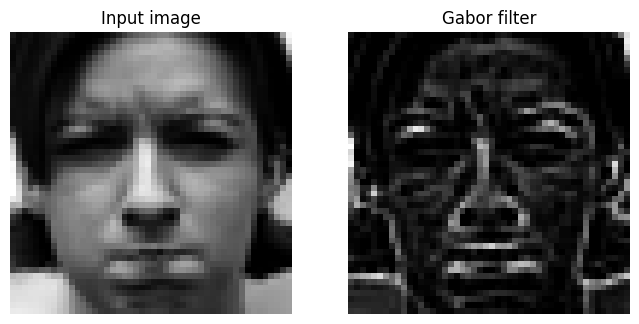

In [64]:
image = ck_images[0]
gabor_image = gabor_process(image)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)
ax1.axis('off')
ax1.imshow(image, cmap='gray')
ax1.set_title('Input image')
ax2.axis('off')
ax2.imshow(gabor_image, cmap='gray')
ax2.set_title('Gabor filter')
plt.show()

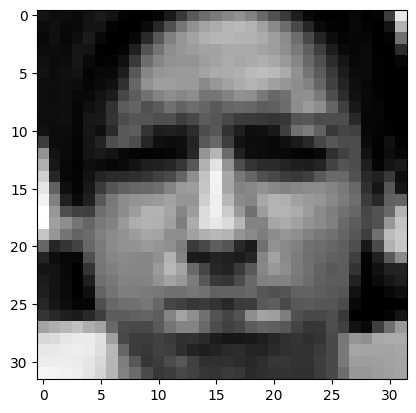

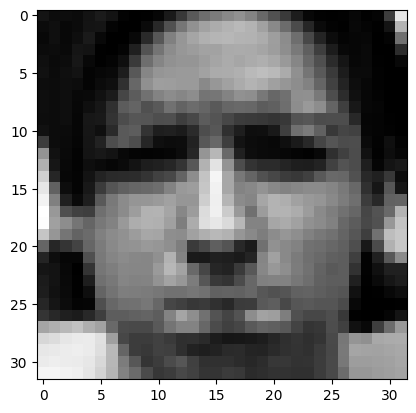

In [79]:
plt.imshow(transform.resize(image, (32, 32))*255, cmap='gray')
plt.show()
plt.imshow((transform.resize(image, (32, 32))*255).astype(np.uint8), cmap='gray')

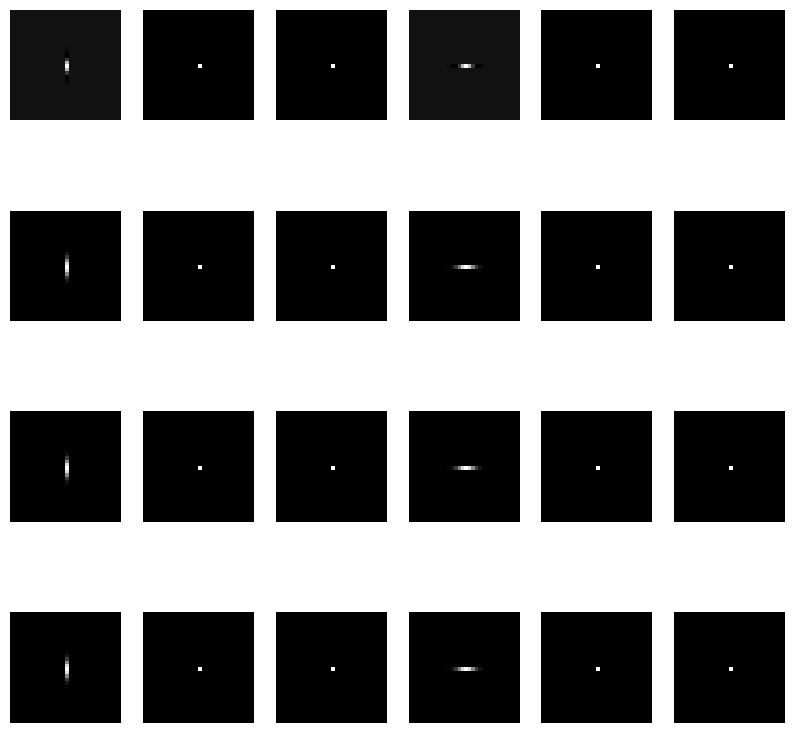

(6, 32, 32)


In [52]:
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt

def gabor_filter(x, y, rx, ry, W, h):
    x0 = x * np.cos(h) + y * np.sin(h)
    y0 = -x * np.sin(h) + y * np.cos(h)
    return np.exp(-0.5 * ((x0 / rx)**2 + (y0 / ry)**2)) * np.cos(2 * np.pi * W * x0)

def gabor_filter_bank(Uh, Ul, S, K, image_size):
    filters = []
    for m in range(S):
        for n in range(K):
            a = (Uh / Ul)**(1/S - 1)
            W = a**m * Ul
            rx = (a - 1) * Uh / ((a + 1) * np.sqrt(2 * np.log(2)))
            rv = np.tan(np.pi / (2 * K)) * W / (2 * np.sqrt(2 * np.log(2)))
            
            for x in range(-image_size // 2, image_size // 2):
                for y in range(-image_size // 2, image_size // 2):
                    filters.append(gabor_filter(x, y, rx, rv, W, n * np.pi / K))
                    
    return np.array(filters).reshape(S, K, image_size, image_size)

def plot_filters(filters, S, K):
    plt.figure(figsize=(10, 10))
    for m in range(S):
        for n in range(K):
            plt.subplot(S, K, m * K + n + 1)
            plt.imshow(filters[m, n], cmap='gray')
            plt.axis('off')
    plt.show()

# Define parameters
Uh = 2.5
Ul = 0.1
S = 4
K = 6
image_size = 32

# Generate Gabor filter bank
gabor_filters = gabor_filter_bank(Uh, Ul, S, K, image_size)

# Plot the filters
plot_filters(gabor_filters, S, K)

print(gabor_filters[0].shape)


In [55]:
# from scipy.ndimage import convolve
# from skimage import color, io

# image = transform.resize(ck_images[0], (32,32))

# # Apply Gabor filter bank to the image
# def apply_gabor_filters(image, filters):
#     filtered_images = np.zeros_like(filters)
#     for m in range(filters.shape[0]):
#         for n in range(filters.shape[1]):
#             filtered_images[m, n] = convolve(image, filters[m, n], mode='constant', cval=0.0)
#     return filtered_images


# # Apply Gabor filter bank to the grayscale image
# filtered_images = apply_gabor_filters(image, gabor_filters)
# plot_filters(filtered_images, S, K)


# With cv2

In [66]:
import cv2
# Function to extract Gabor features from an image
def gabor_features(image, ksize=9, sigma=2.0, theta=0, lambd=5.0, gamma=0.5):
    gabor_filter = cv2.getGaborKernel((ksize, ksize), sigma, theta, lambd, gamma, 0, ktype=cv2.CV_64F)
    filtered_image = cv2.filter2D(image, cv2.CV_8UC3, gabor_filter)
    return filtered_image.flatten()

# Gabor pipeline

In [69]:
from pipelines imort gabor_pipeline

gabor_features = gabor_pipeline(ck_images, verbose=True)
gabor_features.shape

X = gabor_features
y = ck_labels 

train_results, test_results = classifier_pipeline(X, y, verbose=True)

  0%|          | 0/981 [00:00<?, ?it/s]

100%|██████████| 981/981 [05:27<00:00,  2.99it/s]


Train Result:
Accuracy Score: 100.00%
Test Result:
Accuracy Score: 99.66%


In [85]:
from pipelines import gabor_pipeline

gabor_features = gabor_pipeline(jaffe_images, resize=(32,32))
gabor_features.shape

X = gabor_features
y = jaffe_labels 

train_results, test_results = classifier_pipeline(X, y, verbose=True)

100%|██████████| 213/213 [00:08<00:00, 25.58it/s]

Train Result:
Accuracy Score: 100.00%
Test Result:
Accuracy Score: 78.12%


# Gridsearch

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    *preprocessing_pipeline(jaffe_data_path, 'jaffe'),
    test_size=0.25, random_state=42, shuffle=True
)

gabor_sk_pipeline = Pipeline([
    ('gabor_features', GaborTransformer()),
    ('svc', SVC(kernel='rbf', gamma='scale', C= 10))
])

param_grid = {
    'gabor_features__kernel_size': [7, 9, 11],
    'gabor_features__sigma': [0.5, 1.5, 3], # Size of the Filter (σ)
    'gabor_features__gamma': [0.5, 1.2, 3], # Aspect Ratio (γ)
    'gabor_features__lmbda': [1, 5, 10], # Spatial Frequency (λ)
    'gabor_features__psi': [0],
    'gabor_features__angles': [[0,30,60,90,120,150], [0, 45, 90, 135]] # Orientation (θ)
}

grid_search = GridSearchCV(
    estimator=gabor_sk_pipeline,
    param_grid=param_grid,
    scoring='accuracy',
    cv=4,
    verbose=1
)

grid_search.fit(X_train, y_train)
best_params = grid_search.best_params_
best_estimator = grid_search.best_estimator_
print("Best parameters found by grid search:")
print(best_params)


y_train_pred = best_estimator.predict(X_train)
print("\nTest Result:\n================================================")
print(f"Accuracy Score: {accuracy_score(y_train, y_train_pred) * 100:.2f}%")
print("_______________________________________________")
print(f"CLASSIFICATION REPORT:\n{classification_report(y_train, y_train_pred)}")
print("_______________________________________________")
print(f"Confusion Matrix: \n{confusion_matrix(y_train, y_train_pred)}")


y_test_pred = best_estimator.predict(X_test)
print("\nTest Result:\n================================================")
print(f"Accuracy Score: {accuracy_score(y_test, y_test_pred) * 100:.2f}%")
print("_______________________________________________")
print(f"CLASSIFICATION REPORT:\n{classification_report(y_test, y_test_pred)}")
print("_______________________________________________")
print(f"Confusion Matrix: \n{confusion_matrix(y_test, y_test_pred)}")

# Best parameters found by grid search:
# {'gabor_features__angles': [0, 30, 60, 90, 120, 150], 'gabor_features__gamma': 3, 'gabor_features__kernel_size': 11, 'gabor_features__lmbda': 5, 'gabor_features__psi': 0, 'gabor_features__sigma': 3}
# 100%|██████████| 159/159 [00:06<00:00, 23.26it/s]

# Test Result:
# ================================================
# Accuracy Score: 99.37%
# _______________________________________________
# CLASSIFICATION REPORT:
#               precision    recall  f1-score   support

#        Anger       1.00      1.00      1.00        21
#      Disgust       1.00      1.00      1.00        25
#         Fear       1.00      1.00      1.00        22
#    Happiness       0.96      1.00      0.98        23
#      Neutral       1.00      1.00      1.00        21
#      Sadness       1.00      0.96      0.98        26
#     Surprise       1.00      1.00      1.00        21

#     accuracy                           0.99       159
#    macro avg       0.99      0.99      0.99       159
# weighted avg       0.99      0.99      0.99       159

# _______________________________________________
# Confusion Matrix: 
# [[21  0  0  0  0  0  0]
#  [ 0 25  0  0  0  0  0]
#  [ 0  0 22  0  0  0  0]
#  [ 0  0  0 23  0  0  0]
#  [ 0  0  0  0 21  0  0]
#  [ 0  0  0  1  0 25  0]
#  [ 0  0  0  0  0  0 21]]
# 100%|██████████| 54/54 [00:02<00:00, 24.08it/s]

# Test Result:
# ================================================
# Accuracy Score: 87.04%
# _______________________________________________
# CLASSIFICATION REPORT:
#               precision    recall  f1-score   support

#        Anger       1.00      0.89      0.94         9
#      Disgust       0.60      0.75      0.67         4
#         Fear       0.88      0.70      0.78        10
#    Happiness       1.00      0.88      0.93         8
#      Neutral       0.82      1.00      0.90         9
#      Sadness       0.83      1.00      0.91         5
#     Surprise       0.89      0.89      0.89         9

#     accuracy                           0.87        54
#    macro avg       0.86      0.87      0.86        54
# weighted avg       0.88      0.87      0.87        54

# _______________________________________________
# Confusion Matrix: 
# [[8 0 1 0 0 0 0]
#  [0 3 0 0 0 1 0]
#  [0 2 7 0 0 0 1]
#  [0 0 0 7 1 0 0]
#  [0 0 0 0 9 0 0]
#  [0 0 0 0 0 5 0]
#  [0 0 0 0 1 0 8]]


In [5]:
from pipelines import full_gabor_pipeline

train_results, test_results = full_gabor_pipeline(
    ck_data_path, 
    'ck',
    kernel_size=11,
    sigma=1.5,
    gamma=1.2, 
    lmbda=3,
    psi=0,
    angles = [0,30,60,90,120,150],  
    resize = None,
    test_size = 0.3,
    random_state = 42,
    shuffle=True,
    verbose=True
)

# --- PREPROCESSING ---
#   0%|          | 0/981 [00:00<?, ?it/s]
# 100%|██████████| 981/981 [00:03<00:00, 261.38it/s]
# Dataset: ck
# Dataset length: 981
# Image shape: (48, 48)
# --- GABOR ---
# 100%|██████████| 981/981 [06:52<00:00,  2.38it/s]
# kernel size: 11
# sigma: 1.5
# gamma: 1.2
# lambda: 3
# angles: [0, 30, 60, 90, 120, 150]
# Features: (981, 2304)
# --- CLASSIF ---
# ================================================
# Train Result:
# Accuracy Score: 100.00%
# ================================================
# Test Result:
# Accuracy Score: 99.66%

--- PREPROCESSING ---


  0%|          | 0/981 [00:00<?, ?it/s]

100%|██████████| 981/981 [00:03<00:00, 261.38it/s]


Dataset: ck
Dataset length: 981
Image shape: (48, 48)
--- GABOR ---


100%|██████████| 981/981 [06:52<00:00,  2.38it/s]


kernel size: 11
sigma: 1.5
gamma: 1.2
lambda: 3
angles: [0, 30, 60, 90, 120, 150]
Features: (981, 2304)
--- CLASSIF ---
Train Result:
Accuracy Score: 100.00%
Test Result:
Accuracy Score: 99.66%


In [2]:
from pipelines import full_gabor_pipeline

train_results, test_results = full_gabor_pipeline(
    jaffe_data_path, 
    'jaffe',
    kernel_size=11,
    sigma=3,
    gamma=3, 
    lmbda=5,
    psi=0,
    angles = [0,30,60,90,120,150], 
    resize = (32,32),
    test_size = 0.3,
    random_state = 42,
    shuffle=True,
    verbose=True
)

# --- PREPROCESSING ---
# 100%|██████████| 213/213 [00:00<00:00, 976.94it/s]
# Dataset: jaffe
# Dataset length: 213
# Image shape: (256, 256)
# --- GABOR ---
# 100%|██████████| 213/213 [00:44<00:00,  4.84it/s]
# resize: (32, 32)
# kernel size: 11
# sigma: 3
# gamma: 3
# lambda: 5
# angles: [0, 30, 60, 90, 120, 150]
# Features: (213, 1024)
# --- CLASSIF ---
# ================================================
# Train Result:
# Accuracy Score: 99.33%
# ================================================
# Test Result:
# Accuracy Score: 82.81%

--- PREPROCESSING ---


100%|██████████| 213/213 [00:00<00:00, 976.94it/s]


Dataset: jaffe
Dataset length: 213
Image shape: (256, 256)
--- GABOR ---


100%|██████████| 213/213 [00:44<00:00,  4.84it/s]

resize: (32, 32)
kernel size: 11
sigma: 3
gamma: 3
lambda: 5
angles: [0, 30, 60, 90, 120, 150]
Features: (213, 1024)
--- CLASSIF ---
Train Result:
Accuracy Score: 99.33%
Test Result:
Accuracy Score: 82.81%


# cross-val

In [3]:
from pipelines import GaborTransformer

jaffe_images, jaffe_labels = preprocessing_pipeline(jaffe_data_path, 'jaffe')

cv = KFold(n_splits=4, random_state=42, shuffle=True)

gabor_sk_pipeline = Pipeline([
    (
        'gabor_features', GaborTransformer(
            kernel_size=11,
            sigma=3,
            gamma=3, 
            lmbda=5,
            psi=0,
            angles = [0,30,60,90,120,150], 
            resize = (32,32))
    ),
    ('svc', SVC(kernel='rbf', gamma='scale', C= 10))
])

scores = cross_val_score(gabor_sk_pipeline, jaffe_images, jaffe_labels, scoring='accuracy', cv=cv, n_jobs=-1)
print('SVM MEAN  Accuracy: ',str(np.mean(scores)*100)[:5] + '%')
print('Standard deviation: ',str(np.std(scores)*100)[:5] + '%')

# 100%|██████████| 213/213 [00:00<00:00, 985.37it/s] 
# SVM MEAN  Accuracy:  82.13%
# Standard deviation:  3.221%

100%|██████████| 213/213 [00:00<00:00, 985.37it/s] 


SVM MEAN  Accuracy:  82.13%
Standard deviation:  3.221%


In [4]:
from pipelines import GaborTransformer

ck_images, ck_labels = preprocessing_pipeline(ck_data_path, 'ck')

cv = KFold(n_splits=4, random_state=42, shuffle=True)

gabor_sk_pipeline = Pipeline([
    (
        'gabor_features', GaborTransformer(
            kernel_size=11,
            sigma=1.5,
            gamma=1.2, 
            lmbda=3,
            psi=0,
            angles = [0,30,60,90,120,150],  
            resize = None
        )
    ),
    ('svc', SVC(kernel='rbf', gamma='scale', C= 10))
])

scores = cross_val_score(gabor_sk_pipeline, ck_images, ck_labels, scoring='accuracy', cv=cv, n_jobs=-1)
print('SVM MEAN  Accuracy: ',str(np.mean(scores)*100)[:5] + '%')
print('Standard deviation: ',str(np.std(scores)*100)[:5] + '%')

# 100%|██████████| 213/213 [00:00<00:00, 985.37it/s] 
# SVM MEAN  Accuracy:  82.13%
# Standard deviation:  3.221%


  0%|          | 0/981 [00:00<?, ?it/s]

 62%|██████▏   | 612/981 [00:01<00:01, 297.74it/s]